In [1]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import skfuzzy as fuzz
from skfuzzy import control as ctrl
from deap import algorithms, base, creator, tools
import matplotlib.pyplot as plt

In [2]:
iris = load_iris()
X, y = iris.data, iris.target

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
np.max(X_train, axis=0)

array([7.7, 4.4, 6.7, 2.5])

In [5]:
np.min(X_train, axis=0)

array([4.3, 2. , 1. , 0.1])

In [6]:
sepal_length = ctrl.Antecedent(np.arange(4.3, 7.8, 0.1), 'sepal_length')
sepal_width = ctrl.Antecedent(np.arange(2.0, 4.5, 0.1), 'sepal_width')
petal_length = ctrl.Antecedent(np.arange(1.0, 6.8, 0.1), 'petal_length')
petal_width = ctrl.Antecedent(np.arange(0.1, 2.6, 0.1), 'petal_width')
y_class = ctrl.Consequent(np.arange(0, 3, 1), 'y_class')

sl_mid = 4.3 + ((7.7 - 4.3)/2)
sepal_length['poor'] = fuzz.trimf(sepal_length.universe, [4.3, 4.3, sl_mid])
sepal_length['average'] = fuzz.trimf(sepal_length.universe, [4.3, sl_mid, 7.7])
sepal_length['good'] = fuzz.trimf(sepal_length.universe, [sl_mid, 7.7, 7.7])

sw_mid = 2.0 + ((4.4 - 2.0)/2)
sepal_width['poor'] = fuzz.trimf(sepal_width.universe, [2.0, 2.0, sw_mid])
sepal_width['average'] = fuzz.trimf(sepal_width.universe, [2.0, sw_mid, 4.4])
sepal_width['good'] = fuzz.trimf(sepal_width.universe, [sw_mid, 4.4, 4.4])

pl_mid = 1.0 + ((6.7 - 1.0)/2)
petal_length['poor'] = fuzz.trimf(petal_length.universe, [1.0, 1.0, pl_mid])
petal_length['average'] = fuzz.trimf(petal_length.universe, [1.0, pl_mid, 6.7])
petal_length['good'] = fuzz.trimf(petal_length.universe, [pl_mid, 6.7, 6.7])

pw_mid = 0.1 + ((2.5 - 0.1)/2)
petal_width['poor'] = fuzz.trimf(petal_width.universe, [0.1, 0.1, pw_mid])
petal_width['average'] = fuzz.trimf(petal_width.universe, [0.1, pw_mid, 2.5])
petal_width['good'] = fuzz.trimf(petal_width.universe, [pw_mid, 2.5, 2.5])

y_class['Iris-setosa'] = fuzz.trimf(y_class.universe, [0, 0, 1])
y_class['Iris-versicolor'] = fuzz.trimf(y_class.universe, [0, 1, 2])
y_class['Iris-virginica'] = fuzz.trimf(y_class.universe, [1, 2, 2])

In [7]:
rule1 = ctrl.Rule(sepal_length["average"] & sepal_width["average"] & petal_length["poor"] & petal_width["poor"], y_class['Iris-setosa'])
rule2 = ctrl.Rule(sepal_length["average"] & sepal_width["average"] & petal_length["average"] & petal_width["average"], y_class['Iris-versicolor'])
rule3 = ctrl.Rule(sepal_length["good"] & sepal_width["average"] & petal_length["good"] & petal_width["good"], y_class['Iris-virginica'])

In [8]:
iris_ctrl = ctrl.ControlSystem([rule1, rule2, rule3])
classification = ctrl.ControlSystemSimulation(iris_ctrl)

In [9]:
# оцінка функції придатності
def evaluate_system(params):
    # задання параметрів нечіткої системи
    param_sepal_length = params[0]
    param_sepal_width = params[1]
    param_petal_length = params[2]
    param_petal_width = params[3]

    classification.input['sepal_length'] = param_sepal_length
    classification.input['sepal_width'] = param_sepal_width
    classification.input['petal_length'] = param_petal_length
    classification.input['petal_width'] = param_petal_width

    try:
        classification.compute()
        predictions = classification.output['y_class']

        accuracy = accuracy_score(y_test, np.array([round(predictions)] * len(X_test)))
        precision = precision_score(y_test, np.array([round(predictions)] * len(X_test)), average='weighted', zero_division=0)
        recall = recall_score(y_test, np.array([round(predictions)] * len(X_test)), average='weighted')
        f1 = f1_score(y_test, np.array([round(predictions)] * len(X_test)), average='weighted')
        return accuracy, precision, recall, f1

    except:
        return 0, 0, 0, 0

In [10]:
if not hasattr(creator, 'FitnessMulti'):
    creator.create("FitnessMulti", base.Fitness, weights=(5.0, 3.0, 4.0, 1.5))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMulti)

In [11]:
toolbox = base.Toolbox()
toolbox.register("attr_float1", np.random.uniform, 4.3, 7.7)
toolbox.register("attr_float2", np.random.uniform, 2.0, 4.4)
toolbox.register("attr_float3", np.random.uniform, 1.0, 6.7)
toolbox.register("attr_float4", np.random.uniform, 0.1, 2.5)
toolbox.register("individual", tools.initCycle, creator.Individual, (toolbox.attr_float1, toolbox.attr_float2, toolbox.attr_float3, toolbox.attr_float4), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_system)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

gen	nevals
0  	100   
1  	92    
2  	89    
3  	89    
4  	94    
5  	92    
6  	91    
7  	89    
8  	88    
9  	87    
10 	94    
11 	94    
12 	88    
13 	90    
14 	92    
15 	91    
16 	95    
17 	92    
18 	92    
19 	97    
20 	94    
Accuracy on test data: 0.3333333333333333
Precision: 0.1111111111111111
Recall: 0.3333333333333333
F1 Score: 0.16666666666666666


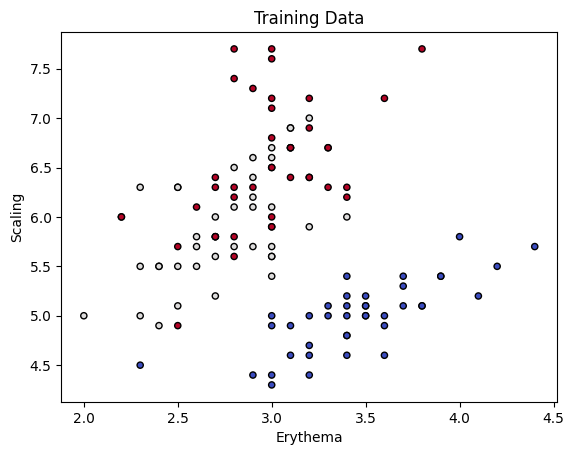

In [12]:
# налаштування EA
population_size = 100
generations = 20
cxpb = 0.5
mutpb = 0.4
pop = toolbox.population(n=population_size)
# визначення алгоритму
algorithm = algorithms.eaMuCommaLambda
population, logbook = algorithm(pop, toolbox, mu=population_size, lambda_=population_size, cxpb=cxpb, mutpb=mutpb, ngen=generations, stats=None, halloffame=None)
# отримання найкращого рішення
best_individual = tools.selBest(pop, 1)[0]
best_params = best_individual
# задання параметрів нечіткої системи з найкращим рішенням
classification.input['sepal_length'] = best_params[0]
classification.input['sepal_width'] = best_params[1]
classification.input['petal_length'] = best_params[2]
classification.input['petal_width'] = best_params[3]

try:
    classification.compute()
    test_predictions = np.array([round(classification.output['y_class'])] * len(X_test))
    best_accuracy, best_precision, best_recall, best_f1 = evaluate_system(best_params)
    # вивід метрик
    print("Accuracy on test data:", best_accuracy)
    print("Precision:", best_precision)
    print("Recall:", best_recall)
    print("F1 Score:", best_f1)
    # діаграма розсіювання навчальних даних
    plt.scatter(X_train[:, 1], X_train[:, 0], c=y_train, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    plt.title("Training Data")
    plt.xlabel("Erythema")
    plt.ylabel("Scaling")
    plt.show()
except ValueError as e:
    print("Error:", e)